In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import phylovelo as pv

/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/sim_utils.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
plt.rcParams['font.size'] = 12

## import `count matrix` and `metadata`

In [3]:
count = pd.read_csv('../../../demo/datasets/tcr/tcr_count_demo.csv', index_col=0)
metadata = pd.read_csv('../../../demo/datasets/tcr/tcr_metadata_demo.csv', index_col=0)

## The 'su009' sample is selected to inference the velocity to avoid batch effect 

In [7]:
sel_cells = metadata[(metadata.patient=='su009').to_numpy()].index

In [8]:
sd = pv.scData(count=count.loc[sel_cells], Xdr=metadata.loc[sel_cells][['UMAP1', 'UMAP2']])

In [9]:
sd.drop_duplicate_genes()
sd.normalize_filter()
sd.cell_states = metadata.loc[sel_cells]['cluster'].to_numpy()

In [10]:
clonesize = metadata.loc[sel_cells].clonesizeInCase.to_numpy()

In [11]:
pv.velocity_inference(sd, np.round(np.log(clonesize)), cutoff=0.97, target='x_normed')

  0%|          | 0/9538 [00:00<?, ?it/s]

/home/wangkun/miniconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


  0%|          | 0/700 [00:00<?, ?it/s]

## Create full sample dataset and transfer the velocity from 'su009' sample. 

In [32]:
sd_full = pv.scData(count=count, Xdr=metadata[['UMAP1', 'UMAP2']])

In [33]:
sd_full.drop_duplicate_genes()
sd_full.normalize_filter()
sd_full.cell_states = metadata['cluster'].to_numpy()

In [34]:
sd_full.x_normed = sd_full.x_normed[sd.x_normed.columns]
sd_full.velocity = sd.velocity

In [35]:
pv.velocity_embedding(sd_full, target='x_normed',n_neigh=300)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [37]:
color_map = {'CD8_act':'#5b91c0',
             'CD8_eff':'#b6dba5',
             'CD8_ex':'#d75859',
             'CD8_ex_act':'#eaa058',
             'CD8_mem':'#6ac6d3',
             'Naive':'#939aa1'}

/tmp/ipykernel_125295/1133422121.py:13: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i in lgnd.legendHandles:


<Axes: xlabel='UMAP 1', ylabel='UMAP 2'>

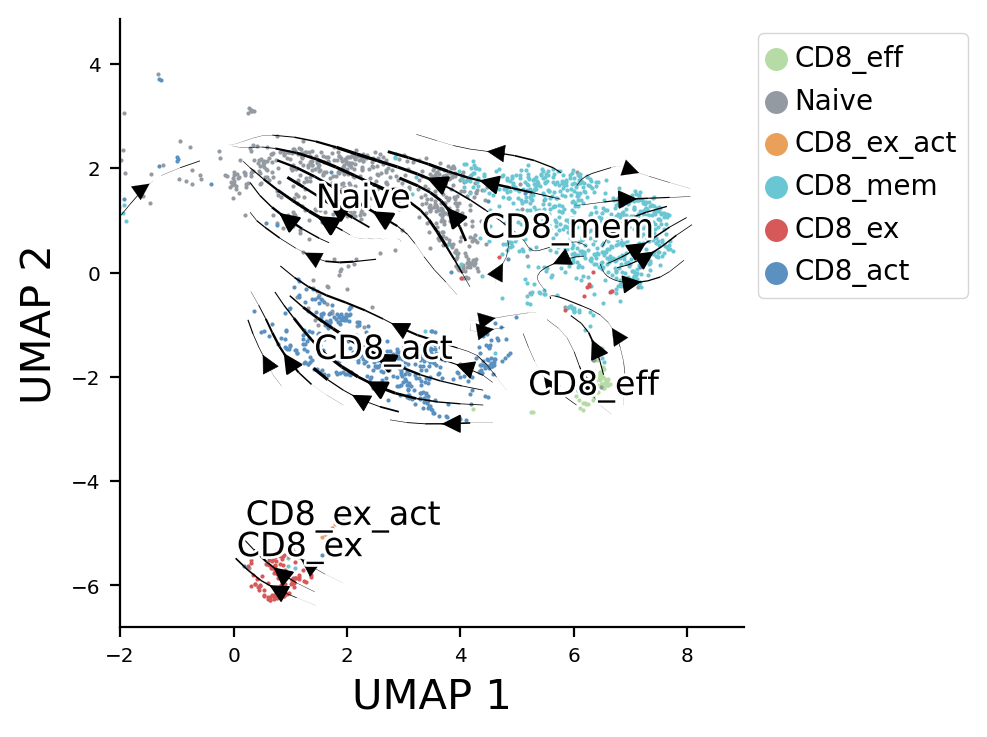

In [38]:
fig, ax = plt.subplots()
for i in set(sd_full.cell_states):
    ax.scatter(sd_full.Xdr.iloc[np.array(sd_full.cell_states)==i, 0], sd_full.Xdr.iloc[np.array(sd_full.cell_states)==i, 1], s=1, label=i, c=color_map[i])
    
ax = pv.velocity_plot(sd_full.Xdr.to_numpy(), sd_full.velocity_embeded, ax, 'stream',streamdensity=1.4, grid_density=40, radius=0.4, lw_coef=8000, arrowsize=1.5)
ax.figure.set_size_inches(4, 4)

ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
lgnd = ax.legend(bbox_to_anchor=(1,1), fontsize=10, loc='upper left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for i in lgnd.legendHandles:
    i._sizes = [60]
ax.set_xlim(-2,9)
pv.label_name(sd_full.Xdr.to_numpy(), sd_full.cell_states, ax)